# pseudo label with deep learning model and majority voting

## using cahya BERT V4

In [1]:
import os
import pandas as pd
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from transformers import BertTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
import torch.nn as nn
from transformers import BertModel

# === Config ===
FOLDS = 5
EPOCHS = 15
BATCH_SIZE = 8
MODEL_NAME = "cahya/bert-base-indonesian-1.5G"
OUTPUT_DIR = "results/V4_CahyaBERT"
SEED = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Seed Control ===
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# === Load Data ===
df = pd.read_csv("sentence_level.csv")
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["type"])
texts = df["bert_context_filtered"].tolist()

# Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# === Normalize Numeric Features ===
to_scale = ["mention_count", "word_count"]
scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])
numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]

# === Dataset Class ===
class SentenceWithNumericDataset(Dataset):
    def __init__(self, texts, labels, numeric_feats, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["numeric_feats"] = self.numeric_feats[idx]
        return item

    def __len__(self):
        return len(self.labels)

# === Custom Model ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name, num_labels, num_numeric_features, class_weights):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# === Custom Collator ===
class CustomCollator:
    def __call__(self, batch):
        input_ids = torch.stack([item["input_ids"] for item in batch])
        attention_mask = torch.stack([item["attention_mask"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        numeric_feats = torch.stack([item["numeric_feats"] for item in batch])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "numeric_feats": numeric_feats
        }

# === Compute Metrics ===
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# === Cross-validation ===
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
fold_metrics = []
cumulative_cm = np.zeros((3, 3), dtype=int)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n📚 Fold {fold + 1}/{FOLDS}")

    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]

    train_numeric = df.iloc[train_idx][numeric_cols].values
    val_numeric = df.iloc[val_idx][numeric_cols].values

    train_dataset = SentenceWithNumericDataset(train_texts, train_labels, train_numeric, tokenizer)
    val_dataset = SentenceWithNumericDataset(val_texts, val_labels, val_numeric, tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IndoBERTWithNumeric(MODEL_NAME, num_labels=3, num_numeric_features=3, class_weights=class_weights_tensor.to(device))

    fold_dir = os.path.join(OUTPUT_DIR, f"fold_{fold+1}")
    os.makedirs(fold_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=fold_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=os.path.join(fold_dir, "logs"),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=50,
        disable_tqdm=True,
        learning_rate=2e-5,
        warmup_steps=100,
        weight_decay=0.01,
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=CustomCollator(),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()

    # === Save clean version of best model for inference ===
    export_path = os.path.join(OUTPUT_DIR, f"best_fold_{fold+1}")
    trainer.save_model(export_path)
    tokenizer.save_pretrained(export_path)

    # === Evaluate ===
    predictions = trainer.predict(val_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    true = np.array(val_labels)

    true_labels = label_encoder.inverse_transform(true)
    pred_labels = label_encoder.inverse_transform(preds)

    report = classification_report(true_labels, pred_labels, output_dict=True, digits=4)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(fold_dir, "classification_report.csv"))

    cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
    cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    cumulative_cm += cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold + 1} (IndoBERT + Numeric)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confusion_matrix.png"))
    plt.close()

    macro = report["macro avg"]
    fold_metrics.append({
        "Fold": fold + 1,
        "Precision": macro["precision"],
        "Recall": macro["recall"],
        "F1": macro["f1-score"],
        "Accuracy": accuracy_score(true_labels, pred_labels)
    })

# === Summary ===
summary_df = pd.DataFrame(fold_metrics)
summary_df.loc["Average"] = summary_df.mean(numeric_only=True)
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary.csv"), index=False)

avg_cm = cumulative_cm // FOLDS
avg_cm_df = pd.DataFrame(avg_cm, index=label_encoder.classes_, columns=label_encoder.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm_df, annot=True, fmt='d', cmap='Purples')
plt.title("Average Confusion Matrix (5-Fold - IndoBERT + Numeric)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "average_confusion_matrix.png"))
plt.close()

print("\n✅ 5-Fold training complete. Results saved to:", OUTPUT_DIR)
print(summary_df)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📚 Fold 1/5


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1025, 'grad_norm': 13.499939918518066, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9453, 'grad_norm': 13.945780754089355, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8313, 'grad_norm': 13.853926658630371, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7234816551208496, 'eval_accuracy': 0.6876971608832808, 'eval_f1': 0.6796302879488091, 'eval_precision': 0.7064663160114074, 'eval_recall': 0.6932458293771245, 'eval_runtime': 0.8067, 'eval_samples_per_second': 392.957, 'eval_steps_per_second': 49.584, 'epoch': 1.0}
{'loss': 0.5336, 'grad_norm': 16.30808448791504, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6336, 'grad_norm': 17.6890811920166, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6158, 'grad_norm': 18.59699058532715, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5633793473243713, 'ev

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.0922, 'grad_norm': 13.378011703491211, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0266, 'grad_norm': 12.59664535522461, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8219, 'grad_norm': 13.720168113708496, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.8257413506507874, 'eval_accuracy': 0.6813880126182965, 'eval_f1': 0.6792773637601224, 'eval_precision': 0.7032581323606295, 'eval_recall': 0.709226780539881, 'eval_runtime': 0.7524, 'eval_samples_per_second': 421.345, 'eval_steps_per_second': 53.167, 'epoch': 1.0}
{'loss': 0.6749, 'grad_norm': 16.093263626098633, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.565, 'grad_norm': 27.511260986328125, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5453, 'grad_norm': 13.385172843933105, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7477670907974243, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1133, 'grad_norm': 12.608789443969727, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 1.0193, 'grad_norm': 9.882536888122559, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8643, 'grad_norm': 17.513830184936523, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6597320437431335, 'eval_accuracy': 0.7160883280757098, 'eval_f1': 0.7158725511184992, 'eval_precision': 0.710200774420958, 'eval_recall': 0.7441712562286913, 'eval_runtime': 0.8207, 'eval_samples_per_second': 386.245, 'eval_steps_per_second': 48.738, 'epoch': 1.0}
{'loss': 0.6008, 'grad_norm': 12.311951637268066, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.6823, 'grad_norm': 13.067063331604004, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.5613, 'grad_norm': 10.773126602172852, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.5385318398475647, '

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.116, 'grad_norm': 13.018996238708496, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9957, 'grad_norm': 13.158970832824707, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.8097, 'grad_norm': 11.582206726074219, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.7650182843208313, 'eval_accuracy': 0.6971608832807571, 'eval_f1': 0.6788452182963943, 'eval_precision': 0.6767173892238492, 'eval_recall': 0.681372934697089, 'eval_runtime': 0.8142, 'eval_samples_per_second': 389.343, 'eval_steps_per_second': 49.128, 'epoch': 1.0}
{'loss': 0.5562, 'grad_norm': 12.04000186920166, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.4676, 'grad_norm': 35.731651306152344, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6585, 'grad_norm': 10.262194633483887, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.7402867674827576, 'e

c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


{'loss': 1.1107, 'grad_norm': 13.523436546325684, 'learning_rate': 1e-05, 'epoch': 0.31446540880503143}
{'loss': 0.9937, 'grad_norm': 7.409126281738281, 'learning_rate': 2e-05, 'epoch': 0.6289308176100629}
{'loss': 0.86, 'grad_norm': 11.293376922607422, 'learning_rate': 1.9562363238512036e-05, 'epoch': 0.9433962264150944}
{'eval_loss': 0.6855285167694092, 'eval_accuracy': 0.7192429022082019, 'eval_f1': 0.7139936218008325, 'eval_precision': 0.7145242494079703, 'eval_recall': 0.7305992656700759, 'eval_runtime': 0.7021, 'eval_samples_per_second': 451.475, 'eval_steps_per_second': 56.968, 'epoch': 1.0}
{'loss': 0.6477, 'grad_norm': 7.500432968139648, 'learning_rate': 1.912472647702407e-05, 'epoch': 1.2578616352201257}
{'loss': 0.5433, 'grad_norm': 20.39215660095215, 'learning_rate': 1.8687089715536106e-05, 'epoch': 1.5723270440251573}
{'loss': 0.6107, 'grad_norm': 16.13271141052246, 'learning_rate': 1.824945295404814e-05, 'epoch': 1.8867924528301887}
{'eval_loss': 0.6791315078735352, 'eval

## majority vote inference

In [2]:
import pandas as pd

# Path to your summary file
summary_path = "results/V4_CahyaBERT/summary.csv"

# Load the summary
summary_df = pd.read_csv(summary_path)

# Drop any average rows if present
summary_df = summary_df[summary_df["Fold"] != "Average"]

# Convert Fold to int if it's not already
summary_df["Fold"] = summary_df["Fold"].astype(int)

# Find the fold with the highest F1 score
best_row = summary_df.loc[summary_df["F1"].idxmax()]
best_fold = int(best_row["Fold"])
best_f1 = best_row["F1"]

print(f"🥇 Best fold is Fold {best_fold} with F1-score = {best_f1:.4f}")


🥇 Best fold is Fold 3 with F1-score = 0.8026


In [1]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from safetensors.torch import load_file

# === CONFIG ===
MODEL_DIR = "results/V4_CahyaBERT/best_fold_3"
CSV_PATH = "sentence_level.csv"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABELS = ["others", "protagonist", "antagonist"]

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")
scaler = StandardScaler()
df[["mention_count", "word_count"]] = scaler.fit_transform(df[["mention_count", "word_count"]])
numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["type"])

# === TOKENIZER ===
tokenizer = BertTokenizer.from_pretrained("cahya/bert-base-indonesian-1.5G")

# === DATASET ===
class SentenceDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df["bert_context_filtered"].tolist(), truncation=True, padding=True, max_length=128)
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float)
        self.labels = torch.tensor(df["label_encoded"].values)
        self.metadata = df[["story_id", "person", "sentence_id", "type"]].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["numeric_feats"] = self.numeric_feats[idx]
        item["labels"] = self.labels[idx]
        item["meta"] = self.metadata.loc[idx].to_dict()
        return item

# === CUSTOM COLLATOR ===
def custom_collate_fn(batch):
    keys = batch[0].keys()
    collated = {k: [d[k] for d in batch] for k in keys}
    for k in ["input_ids", "attention_mask", "labels", "numeric_feats"]:
        collated[k] = torch.stack(collated[k])
    return collated

# === MODEL ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name="cahya/bert-base-indonesian-1.5G", num_labels=3, num_numeric_features=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        return logits

# === LOAD MODEL ===
model = IndoBERTWithNumeric()
state_dict = load_file(os.path.join(MODEL_DIR, "model.safetensors"))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()

# === INFERENCE ===
dataset = SentenceDataset(df)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

all_results = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        numeric_feats = batch["numeric_feats"].to(DEVICE)
        logits = model(input_ids=input_ids, attention_mask=attention_mask, numeric_feats=numeric_feats)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        for i in range(len(preds)):
            meta = batch["meta"][i]
            all_results.append({
                "story_id": meta["story_id"],
                "person": meta["person"],
                "sentence_id": meta["sentence_id"],
                "true_type": meta["type"],
                "predicted_type": label_encoder.inverse_transform([preds[i]])[0],
                "confidence_protagonist": probs[i][1],
                "confidence_antagonist": probs[i][2],
                "confidence_others": probs[i][0]
            })

# === SAVE SENTENCE-LEVEL PREDICTIONS ===
output_dir = "results/pseudo_vote"
os.makedirs(output_dir, exist_ok=True)

pred_df = pd.DataFrame(all_results)
pred_df.to_csv(os.path.join(output_dir, "sentence_predictions.csv"), index=False)

# === MAJORITY VOTE PER CHARACTER ===
agg_df = pred_df.groupby(["story_id", "person"]).agg({
    "predicted_type": lambda x: x.value_counts().idxmax(),
    "true_type": lambda x: x.value_counts().idxmax()
}).reset_index()
agg_df.to_csv(os.path.join(output_dir, "character_predictions.csv"), index=False)

# === EVALUATION ===
y_true = agg_df["true_type"]
y_pred = agg_df["predicted_type"]
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(output_dir, "character_level_report.csv"))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
print("\n📉 Confusion Matrix:")
print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

# === PRINT SUMMARY METRICS ===
print("\n🏅 Summary (Majority Vote on Sentence Predictions):")
for label in label_encoder.classes_:
    p = report[label]["precision"]
    r = report[label]["recall"]
    f1 = report[label]["f1-score"]
    support = report[label]["support"]
    print(f"{label:<12}  precision: {p:.4f}  recall: {r:.4f}  f1-score: {f1:.4f}  support: {support:.0f}")

print(f"\n✅ Overall Metrics:")
print(f"accuracy        : {report['accuracy']:.4f}")
print(f"macro avg f1    : {report['macro avg']['f1-score']:.4f}")
print(f"weighted avg f1 : {report['weighted avg']['f1-score']:.4f}")


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📉 Confusion Matrix:
             antagonist  others  protagonist
antagonist           24       0            1
others                1      98            5
protagonist           6       4           52

🏅 Summary (Majority Vote on Sentence Predictions):
antagonist    precision: 0.7742  recall: 0.9600  f1-score: 0.8571  support: 25
others        precision: 0.9608  recall: 0.9423  f1-score: 0.9515  support: 104
protagonist   precision: 0.8966  recall: 0.8387  f1-score: 0.8667  support: 62

✅ Overall Metrics:
accuracy        : 0.9110
macro avg f1    : 0.8918
weighted avg f1 : 0.9116


## cumulative character-level voting across iterations

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from collections import Counter, defaultdict

# === CONFIG ===
MODEL_DIR = "results/V4_CahyaBERT/best_fold_3"
CSV_PATH = "sentence_level.csv"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ITERATIONS = 5
OUTPUT_DIR = "results/iterative_vote"
LABELS = ["others", "protagonist", "antagonist"]

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")
scaler = StandardScaler()
df[["mention_count", "word_count"]] = scaler.fit_transform(df[["mention_count", "word_count"]])
numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["type"])

# === TOKENIZER ===
tokenizer = BertTokenizer.from_pretrained("cahya/bert-base-indonesian-1.5G")

# === DATASET ===
class SentenceDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df["bert_context_filtered"].tolist(), truncation=True, padding=True, max_length=128)
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float)
        self.labels = torch.tensor(df["label_encoded"].values)
        self.metadata = df[["story_id", "person", "sentence_id", "type"]].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["numeric_feats"] = self.numeric_feats[idx]
        item["labels"] = self.labels[idx]
        item["meta"] = self.metadata.loc[idx].to_dict()
        return item

# === COLLATE ===
def custom_collate_fn(batch):
    keys = batch[0].keys()
    collated = {k: [d[k] for d in batch] for k in keys}
    for k in ["input_ids", "attention_mask", "labels", "numeric_feats"]:
        collated[k] = torch.stack(collated[k])
    return collated

# === MODEL ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name="cahya/bert-base-indonesian-1.5G", num_labels=3, num_numeric_features=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        return logits

# === LOAD MODEL ===
model = IndoBERTWithNumeric()
state_dict = load_file(os.path.join(MODEL_DIR, "model.safetensors"))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()

# === INFERENCE ===
dataset = SentenceDataset(df)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

predictions_per_sentence = [[] for _ in range(len(df))]

print("\n🔁 Starting Iterative Inference and Voting")
for iteration in range(ITERATIONS):
    print(f"\n🔁 Iteration {iteration + 1}")
    idx = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            numeric_feats = batch["numeric_feats"].to(DEVICE)
            logits = model(input_ids=input_ids, attention_mask=attention_mask, numeric_feats=numeric_feats)
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1).cpu().numpy()

            for p in preds:
                predictions_per_sentence[idx].append(p)
                idx += 1

# === MAJORITY VOTE PER SENTENCE ===
final_preds_sentence = [Counter(votes).most_common(1)[0][0] for votes in predictions_per_sentence]
df["predicted_type_sentence"] = label_encoder.inverse_transform(final_preds_sentence)

# === MAJORITY VOTE PER CHARACTER ===
character_votes = defaultdict(list)

for _, row in df.iterrows():
    key = (row["story_id"], row["person"])
    character_votes[key].append(row["predicted_type_sentence"])

character_final_preds = []
character_true_labels = []
character_ids = []

for (story_id, person), votes in character_votes.items():
    voted = Counter(votes).most_common(1)[0][0]
    true_type = df[(df["story_id"] == story_id) & (df["person"] == person)]["type"].mode()[0]
    character_ids.append((story_id, person))
    character_final_preds.append(voted)
    character_true_labels.append(true_type)

# === EVALUATION ===
y_true = character_true_labels
y_pred = character_final_preds

report = classification_report(y_true, y_pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, "character_level_report_majority_across_iterations.csv"))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
print("\n📉 Confusion Matrix (Character-Level Majority Across Iterations):")
print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

# === PRINT METRICS ===
print("\n🏅 Summary (Iterative Voting per Character):")
for label in LABELS:
    p = report[label]["precision"]
    r = report[label]["recall"]
    f1 = report[label]["f1-score"]
    s = report[label]["support"]
    print(f"{label:<12}  precision: {p:.4f}  recall: {r:.4f}  f1-score: {f1:.4f}  support: {int(s)}")

print(f"\n✅ Overall Metrics:")
print(f"accuracy        : {report['accuracy']:.4f}")
print(f"macro avg f1    : {report['macro avg']['f1-score']:.4f}")
print(f"weighted avg f1 : {report['weighted avg']['f1-score']:.4f}")

# === SAVE PREDICTIONS ===
char_pred_df = pd.DataFrame(character_ids, columns=["story_id", "person"])
char_pred_df["true_type"] = y_true
char_pred_df["predicted_type"] = y_pred
char_pred_df.to_csv(os.path.join(OUTPUT_DIR, "character_predictions_majority_across_iterations.csv"), index=False)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🔁 Starting Iterative Inference and Voting

🔁 Iteration 1

🔁 Iteration 2

🔁 Iteration 3

🔁 Iteration 4

🔁 Iteration 5

📉 Confusion Matrix (Character-Level Majority Across Iterations):
             antagonist  others  protagonist
antagonist           24       0            1
others                1      98            5
protagonist           6       4           52

🏅 Summary (Iterative Voting per Character):
others        precision: 0.9608  recall: 0.9423  f1-score: 0.9515  support: 104
protagonist   precision: 0.8966  recall: 0.8387  f1-score: 0.8667  support: 62
antagonist    precision: 0.7742  recall: 0.9600  f1-score: 0.8571  support: 25

✅ Overall Metrics:
accuracy        : 0.9110
macro avg f1    : 0.8918
weighted avg f1 : 0.9116


## confidence weigthted vote

In [2]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from collections import defaultdict

# === CONFIG ===
MODEL_DIR = "results/V4_CahyaBERT/best_fold_3"
CSV_PATH = "sentence_level.csv"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ITERATIONS = 5
OUTPUT_DIR = "results/confidence_vote"
LABELS = ["others", "protagonist", "antagonist"]
label_to_index = {label: i for i, label in enumerate(LABELS)}
index_to_label = {i: label for label, i in label_to_index.items()}

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")
scaler = StandardScaler()
df[["mention_count", "word_count"]] = scaler.fit_transform(df[["mention_count", "word_count"]])
numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["type"])

# === TOKENIZER ===
tokenizer = BertTokenizer.from_pretrained("cahya/bert-base-indonesian-1.5G")

# === DATASET ===
class SentenceDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df["bert_context_filtered"].tolist(), truncation=True, padding=True, max_length=128)
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float)
        self.labels = torch.tensor(df["label_encoded"].values)
        self.metadata = df[["story_id", "person", "sentence_id", "type"]].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["numeric_feats"] = self.numeric_feats[idx]
        item["labels"] = self.labels[idx]
        item["meta"] = self.metadata.loc[idx].to_dict()
        return item

# === COLLATE ===
def custom_collate_fn(batch):
    keys = batch[0].keys()
    collated = {k: [d[k] for d in batch] for k in keys}
    for k in ["input_ids", "attention_mask", "labels", "numeric_feats"]:
        collated[k] = torch.stack(collated[k])
    return collated

# === MODEL ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name="cahya/bert-base-indonesian-1.5G", num_labels=3, num_numeric_features=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        return logits

# === LOAD MODEL ===
model = IndoBERTWithNumeric()
state_dict = load_file(os.path.join(MODEL_DIR, "model.safetensors"))
model.load_state_dict(state_dict, strict=False)
model.to(DEVICE)
model.eval()

# === INFERENCE ===
dataset = SentenceDataset(df)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

# === STORE WEIGHTED CONFIDENCE PER CHARACTER ===
character_confidences = defaultdict(lambda: np.zeros(len(LABELS)))
character_true_types = {}

print("\n🔁 Starting Iterative Inference and Confidence-Weighted Voting")
for iteration in range(ITERATIONS):
    print(f"\n🔁 Iteration {iteration + 1}")
    idx = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            numeric_feats = batch["numeric_feats"].to(DEVICE)
            logits = model(input_ids=input_ids, attention_mask=attention_mask, numeric_feats=numeric_feats)
            probs = F.softmax(logits, dim=1).cpu().numpy()

            for i, meta in enumerate(batch["meta"]):
                key = (meta["story_id"], meta["person"])
                character_confidences[key] += probs[i]
                character_true_types[key] = meta["type"]
                idx += 1

# === FINAL PREDICTIONS ===
character_final_preds = []
character_true_labels = []
character_ids = []

for (story_id, person), conf_vector in character_confidences.items():
    final_label = index_to_label[np.argmax(conf_vector)]
    character_final_preds.append(final_label)
    character_true_labels.append(character_true_types[(story_id, person)])
    character_ids.append((story_id, person))

# === EVALUATION ===
y_true = character_true_labels
y_pred = character_final_preds
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, "character_level_report_confidence_weighted.csv"))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
print("\n📉 Confusion Matrix (Confidence-Weighted Voting):")
print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

# === PRINT METRICS ===
print("\n🏅 Summary (Confidence-Weighted Voting per Character):")
for label in LABELS:
    p = report[label]["precision"]
    r = report[label]["recall"]
    f1 = report[label]["f1-score"]
    s = report[label]["support"]
    print(f"{label:<12}  precision: {p:.4f}  recall: {r:.4f}  f1-score: {f1:.4f}  support: {int(s)}")

print(f"\n✅ Overall Metrics:")
print(f"accuracy        : {report['accuracy']:.4f}")
print(f"macro avg f1    : {report['macro avg']['f1-score']:.4f}")
print(f"weighted avg f1 : {report['weighted avg']['f1-score']:.4f}")

# === SAVE PREDICTIONS ===
char_pred_df = pd.DataFrame(character_ids, columns=["story_id", "person"])
char_pred_df["true_type"] = y_true
char_pred_df["predicted_type"] = y_pred
char_pred_df.to_csv(os.path.join(OUTPUT_DIR, "character_predictions_confidence_weighted.csv"), index=False)


🔁 Starting Iterative Inference and Confidence-Weighted Voting

🔁 Iteration 1

🔁 Iteration 2

🔁 Iteration 3

🔁 Iteration 4

🔁 Iteration 5

📉 Confusion Matrix (Confidence-Weighted Voting):
             antagonist  others  protagonist
antagonist            1      24            0
others                5       1           98
protagonist          53       6            3

🏅 Summary (Confidence-Weighted Voting per Character):
others        precision: 0.0323  recall: 0.0096  f1-score: 0.0148  support: 104
protagonist   precision: 0.0297  recall: 0.0484  f1-score: 0.0368  support: 62
antagonist    precision: 0.0169  recall: 0.0400  f1-score: 0.0238  support: 25

✅ Overall Metrics:
accuracy        : 0.0262
macro avg f1    : 0.0251
weighted avg f1 : 0.0231


## ensemble voting folds

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from safetensors.torch import load_file
from collections import Counter, defaultdict

# === CONFIG ===
BASE_MODEL_DIR = "results/V4_CahyaBERT"
CSV_PATH = "sentence_level.csv"
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABELS = ["others", "protagonist", "antagonist"]
OUTPUT_DIR = "results/ensemble_majority"
FOLDS = 5

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df["bert_context_filtered"] = df["bert_context_filtered"].fillna("")
scaler = StandardScaler()
df[["mention_count", "word_count"]] = scaler.fit_transform(df[["mention_count", "word_count"]])
numeric_cols = ["mention_count", "word_count", "is_primary_in_sentence"]
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["type"])

# === TOKENIZER ===
tokenizer = BertTokenizer.from_pretrained("cahya/bert-base-indonesian-1.5G")

# === DATASET ===
class SentenceDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df["bert_context_filtered"].tolist(), truncation=True, padding=True, max_length=128)
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float)
        self.labels = torch.tensor(df["label_encoded"].values)
        self.metadata = df[["story_id", "person", "sentence_id", "type"]].reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["numeric_feats"] = self.numeric_feats[idx]
        item["labels"] = self.labels[idx]
        item["meta"] = self.metadata.loc[idx].to_dict()
        return item

# === COLLATE ===
def custom_collate_fn(batch):
    keys = batch[0].keys()
    collated = {k: [d[k] for d in batch] for k in keys}
    for k in ["input_ids", "attention_mask", "labels", "numeric_feats"]:
        collated[k] = torch.stack(collated[k])
    return collated

# === MODEL ===
class IndoBERTWithNumeric(nn.Module):
    def __init__(self, model_name="cahya/bert-base-indonesian-1.5G", num_labels=3, num_numeric_features=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size + num_numeric_features, num_labels)

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined = torch.cat((pooled_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))
        return logits

# === INFERENCE ACROSS FOLDS ===
predictions_per_sentence = [[] for _ in range(len(df))]
dataset = SentenceDataset(df)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

print("\n🔁 Starting Ensemble Voting Across Folds")

for fold_idx in range(FOLDS):
    fold_dir = os.path.join(BASE_MODEL_DIR, f"best_fold_{fold_idx + 1}")
    print(f"\n🔁 Fold {fold_idx + 1}")
    model = IndoBERTWithNumeric()
    state_dict = load_file(os.path.join(fold_dir, "model.safetensors"))
    model.load_state_dict(state_dict, strict=False)
    model.to(DEVICE)
    model.eval()

    idx = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            numeric_feats = batch["numeric_feats"].to(DEVICE)
            logits = model(input_ids=input_ids, attention_mask=attention_mask, numeric_feats=numeric_feats)
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1).cpu().numpy()
            for p in preds:
                predictions_per_sentence[idx].append(p)
                idx += 1

# === MAJORITY VOTE PER SENTENCE ===
final_preds_sentence = [Counter(votes).most_common(1)[0][0] for votes in predictions_per_sentence]
df["predicted_type_sentence"] = label_encoder.inverse_transform(final_preds_sentence)

# === MAJORITY VOTE PER CHARACTER ===
character_votes = defaultdict(list)

for _, row in df.iterrows():
    key = (row["story_id"], row["person"])
    character_votes[key].append(row["predicted_type_sentence"])

character_final_preds = []
character_true_labels = []
character_ids = []

for (story_id, person), votes in character_votes.items():
    voted = Counter(votes).most_common(1)[0][0]
    true_type = df[(df["story_id"] == story_id) & (df["person"] == person)]["type"].mode()[0]
    character_ids.append((story_id, person))
    character_final_preds.append(voted)
    character_true_labels.append(true_type)

# === EVALUATION ===
y_true = character_true_labels
y_pred = character_final_preds

report = classification_report(y_true, y_pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, "character_level_report_ensemble_majority.csv"))

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
print("\n📉 Confusion Matrix (Character-Level Ensemble Majority):")
print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

print("\n🏅 Summary (Ensemble Voting per Character):")
for label in LABELS:
    p = report[label]["precision"]
    r = report[label]["recall"]
    f1 = report[label]["f1-score"]
    s = report[label]["support"]
    print(f"{label:<12}  precision: {p:.4f}  recall: {r:.4f}  f1-score: {f1:.4f}  support: {int(s)}")

print(f"\n✅ Overall Metrics:")
print(f"accuracy        : {report['accuracy']:.4f}")
print(f"macro avg f1    : {report['macro avg']['f1-score']:.4f}")
print(f"weighted avg f1 : {report['weighted avg']['f1-score']:.4f}")

# === SAVE FINAL CHARACTER-LEVEL PREDICTIONS ===
char_pred_df = pd.DataFrame(character_ids, columns=["story_id", "person"])
char_pred_df["true_type"] = y_true
char_pred_df["predicted_type"] = y_pred
char_pred_df.to_csv(os.path.join(OUTPUT_DIR, "character_predictions_ensemble_majority.csv"), index=False)


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🔁 Starting Ensemble Voting Across Folds

🔁 Fold 1

🔁 Fold 2

🔁 Fold 3

🔁 Fold 4

🔁 Fold 5

📉 Confusion Matrix (Character-Level Ensemble Majority):
             antagonist  others  protagonist
antagonist           22       0            3
others                2      96            6
protagonist           1       3           58

🏅 Summary (Ensemble Voting per Character):
others        precision: 0.9697  recall: 0.9231  f1-score: 0.9458  support: 104
protagonist   precision: 0.8657  recall: 0.9355  f1-score: 0.8992  support: 62
antagonist    precision: 0.8800  recall: 0.8800  f1-score: 0.8800  support: 25

✅ Overall Metrics:
accuracy        : 0.9215
macro avg f1    : 0.9083
weighted avg f1 : 0.9221


: 

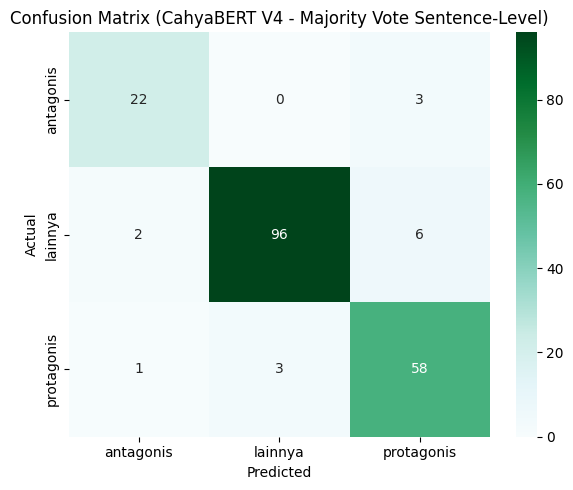

📌 Macro Precision : 0.9051
📌 Macro Recall    : 0.9129


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# === INPUT MANUAL CONFUSION MATRIX (dari hasil ensemble vote) ===
# Format: rows = actual, cols = predicted
cm = np.array([
    [22, 0, 3],     # Actual: antagonist
    [2, 96, 6],     # Actual: others
    [1, 3, 58]      # Actual: protagonist
])

# === LABELS ===
labels_en = ['antagonist', 'others', 'protagonist']
labels_id = ['antagonis', 'lainnya', 'protagonis']

# === CONFUSION MATRIX PLOT ===
cm_df = pd.DataFrame(cm, index=labels_id, columns=labels_id)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='BuGn')
plt.title("Confusion Matrix (CahyaBERT V4 - Majority Vote Sentence-Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("character_level_confusion_matrix_single_vote.png")
plt.show()

# === FLATTEN TO GET TRUE & PRED LABELS ===
y_true = []
y_pred = []

for i, actual_class in enumerate(labels_en):
    for j, pred_class in enumerate(labels_en):
        count = cm[i, j]
        y_true.extend([actual_class] * count)
        y_pred.extend([pred_class] * count)

# === COMPUTE METRICS ===
macro_precision = precision_score(y_true, y_pred, labels=labels_en, average='macro')
macro_recall = recall_score(y_true, y_pred, labels=labels_en, average='macro')

print(f"📌 Macro Precision : {macro_precision:.4f}")
print(f"📌 Macro Recall    : {macro_recall:.4f}")
